In [2]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [4]:
df_movies = pd.read_csv('./data/movie_lens/movies.csv',
                        usecols=['movieId', 'title'],
                        dtype={'movieId' : 'int32', 'title' : 'str'})

df_ratings = pd.read_csv('./data/movie_lens/ratings.csv',
                        usecols=['userId', 'movieId', 'rating'],
                        dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int32 
 1   title    9125 non-null   object
dtypes: int32(1), object(1)
memory usage: 107.1+ KB


In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int32  
 1   movieId  100004 non-null  int32  
 2   rating   100004 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.1 MB


In [7]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [8]:
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


movies 데이터 에서는 title만 쓰고, ratings 데이터에서는 user ID와 rating만 사용하겠습니다.

In [11]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())

print('unique users: {} \nunique movies: {} '.format(num_users, num_items))

unique users: 671 
unique movies: 9066 


## EDA

### 각 rating 개수 세기

In [14]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


위의 표에서 rating 점수를 보면 0점으로 평점을 준 내용이 빠져있습니다. 

In [19]:
print('사용자가 평점을 줄 수 있는 총 경우의 수: {}'.format(num_users* num_items))
print('사용자가 평점을 매긴 총 평점의 수: {}'.format(df_ratings.shape[0]))

사용자가 평점을 줄 수 있는 총 경우의 수: 6083286
사용자가 평점을 매긴 총 평점의 수: 100004


사용자가 평점을 매겼든 안매겼든 평점의 개수를 샌 dataframe을 채워줄 필요가 있습니다. 임의로 0을 넣어보겠습니다.

In [20]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True, # index 중복 확인
).sort_index()

df_ratings_cnt

,count
0.0,5983282
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


0.0을 추가하고 보니까 0.0에 너무 쏠려있습니다. 그래서 log 변환을 취하겠습니다.

In [21]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5983282,15.604480
0.5,1101,7.003974
1.0,3326,8.109526
1.5,1687,7.430707
2.0,7271,8.891649
2.5,4449,8.400435
3.0,20064,9.906682
3.5,10538,9.262743
4.0,28750,10.266393
4.5,7723,8.951958


Text(0, 0.5, 'number of ratings')

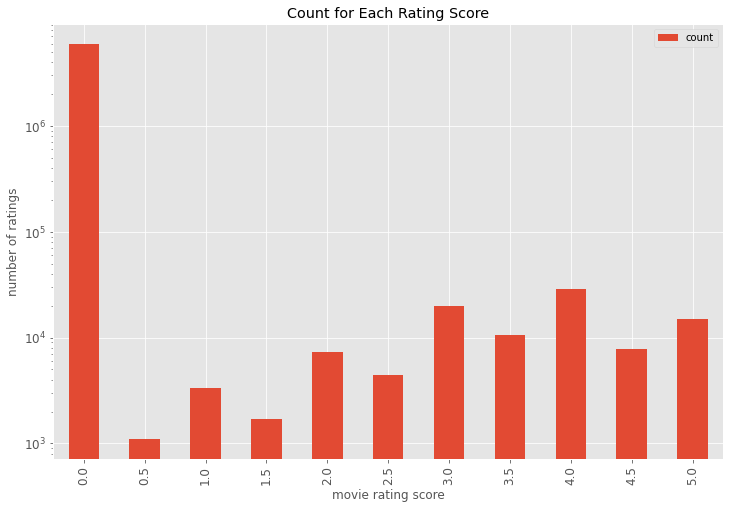

In [22]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    logy = True,
    fontsize = 12,
)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

3점과 4점을 준 사용자의 비율이 다른 평점에 비해서 높아보입니다.

### 전체 영화에 대한 평점 빈도

In [23]:
df_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [24]:
# 각 영화에 대한 평점 개수를 합칩니다
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,247
2,107
3,59
4,13
5,56


Text(0, 0.5, 'number of ratings')

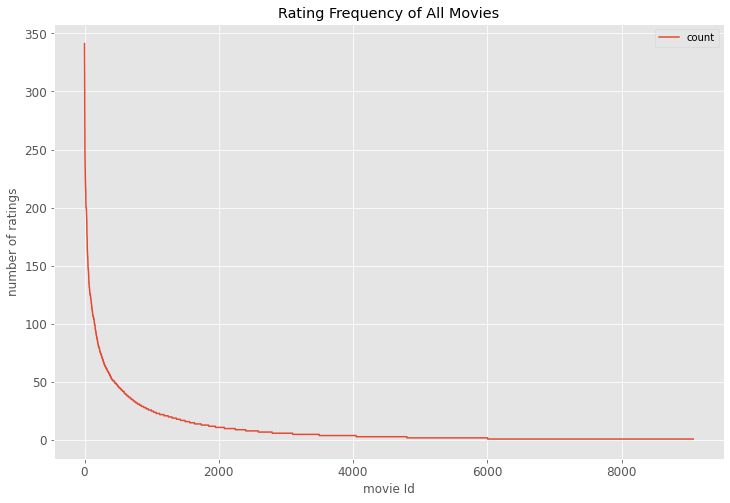

In [26]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

위의 그래프를 보면 긴 꼬리 처럼 생긴 롱테일 법칙이 성립됩니다. 롱테일의 법칙이란 80%의 소소한 다수가 20%의 핵심 소수보다 더 큰 가치를 창출한다는 법칙입니다. log scale을 취해서 더 자세하게 살펴보겠습니다. 

Text(0, 0.5, 'number of ratings')

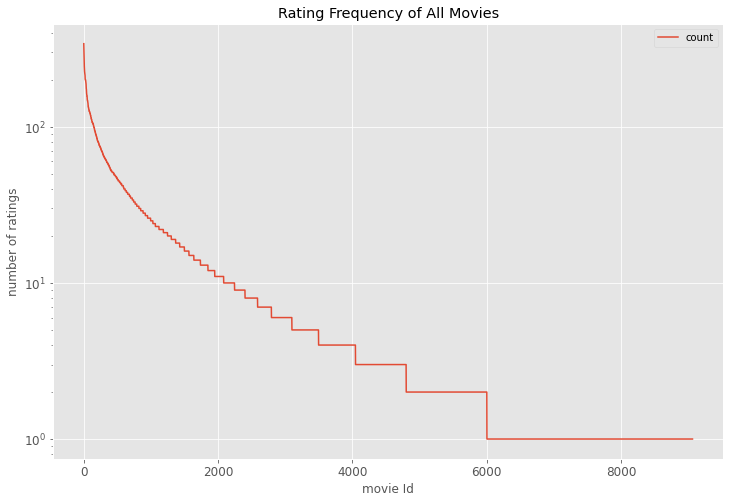

In [25]:
# 전체 평점 수에 대한 그래프를 그립니다.
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12,8),
        title='Rating Frequency of All Movies',
        fontsize=12,
        logy=True
    )

ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

In [30]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    341.0
0.95     49.0
0.90     28.0
0.85     19.0
0.80     13.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

수치적으로 보자면 1%의 movie는 341개의 평점 데이터를 가지고 있고, 5%는 49개, 20%는 13개의 데이터를 가지고 있습니다. 데이터가 많다면 적은 평점의 개수를 가지고 있는 데이터는 drop해도 되지만 빼지 않겠습니다. 

## 아이템 기반 협업필터링 KNN model 

### Reshaping the Data

KNN 모델에 데이터를 넣기 전에 우리가 가지고 있는 데이터를 변형할 필요가 있습니다. 우리는 movie와 user간의 상관관계를 분석하여 추천시스템을 구현하고자 합니다. 그래서 user-movie 간의 pivot 테이블을 만들어주겠습니다. 그리고 linear lagebra 연산을 사용하기 위해서 비어있는 공간을 0으로 채우겠습니다.  

In [32]:
movie_user_mat = df_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

movie_to_idx = {
    movie: i for i, movie in
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}

movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

### Fitting the Model

NearestNeighbors class를 KNN model으로 초기화 하고 sparse matrix를 인스턴스에 맞춥니다. metric은 cosine으로 지정해서 코사인 유사도를 통해 벡터의 관계를 비교합니다. 

In [36]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

## 추천 시스템 사용하기

In [78]:
"""
    return the closest match via fuzzy ratio. If no match found, return None

    Parameters
    ----------    
    mapper: dict, movie title name을 index 형식으로 맵핑

    fav_movie: str, user가 넣어준 영화 이름

    verbose: bool, 실행 로그를 넣어줌

    Return
    ------
    index of the closest match
"""

def fuzzy_matching(mapper, fav_movie, verbose=True):
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('데이터베이스에서 가능한 일치 항목을 찾았습니다: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [79]:
"""
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
"""
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    
    # fit
    model_knn.fit(data)
    # get input movie index
    print('입력으로 넣은 영화:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('추천 시스템이 inference를 시작합니다.')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('{}과 관련된 추천 영화 리스트:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1} '.format(i+1, reverse_mapper[idx]), end=' ')
        print('-'*(30-len(reverse_mapper[idx])), end=' ')
        print('유사도: {}'.format(round(dist, 3)))      

In [80]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

입력으로 넣은 영화: Iron Man
데이터베이스에서 가능한 일치 항목을 찾았습니다: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

추천 시스템이 inference를 시작합니다.
......

Iron Man과 관련된 추천 영화 리스트:
1: Sherlock Holmes (2009)  -------- 유사도: 0.444
2: Casino Royale (2006)  ---------- 유사도: 0.438
3: Guardians of the Galaxy (2014)   유사도: 0.436
4: 300 (2007)  -------------------- 유사도: 0.417
5: WALL·E (2008)  ----------------- 유사도: 0.416
6: Avengers, The (2012)  ---------- 유사도: 0.374
7: Avatar (2009)  ----------------- 유사도: 0.367
8: Batman Begins (2005)  ---------- 유사도: 0.366
9: Star Trek (2009)  -------------- 유사도: 0.358
10: Dark Knight, The (2008)  ------- 유사도: 0.267


In [82]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('movie와 user 행렬에 {:.2%} 이나 되는 평점 데이터가 존재하지 않습니다.'.format(ratio_zeros))

movie와 user 행렬에 98.36% 이나 되는 평점 데이터가 존재하지 않습니다.


평점 데이터가 98%나 존재하지 않는다는 것은 추천시스템에 활용하기엔 데이터 정보가 너무 부족하다는 것입니다. 이러한 문제를 **Cold Start** 문제라고 부릅니다.